# Introduction

## Context

Sendy, in partnership with insight2impact facility, is hosting a Zindi challenge to predict the estimated time of delivery of orders, from the point of driver pickup to the point of arrival at final destination.

The solution will help Sendy enhance customer communication and improve the reliability of its service; which will ultimately improve customer experience. In addition, the solution will enable Sendy to realise cost savings, and ultimately reduce the cost of doing business, through improved resource management and planning for order scheduling.

Sendy helps men and women behind every type of business to trade easily, deliver more competitively, and build extraordinary businesses.

## Problem Statement

Data is a critical component in helping Sendy to build more efficient, affordable and accessible solutions. Given the details of a Sendy order, can we use historic data to predict an accurate time for the arrival of the rider at the destination of a package? In this competition, we’re challenging you to build a model that predicts an accurate delivery time, from picking up a package to arriving at the final destination. An accurate arrival time prediction will help all businesses to improve their logistics and communicate an accurate time to their customers.

# Data Exploration

## Import packages and load data files

###### task: mport and load data

In [1]:
# import packages
import pprint
import pandas as pd
import numpy as np
import itertools
import statsmodels.api as sm
from datetime import datetime, date

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

%matplotlib inline

pp = pprint.PrettyPrinter()

In [2]:
# load data
train_data = pd.read_csv(r'C:\Users\tbndo\Google Drive\Projects\regression-predict-api-template\predict deliverable\data\Train.csv')
test_data = pd.read_csv(r'C:\Users\tbndo\Google Drive\Projects\regression-predict-api-template\predict deliverable\data\Test.csv')
riders_data = pd.read_csv(r'C:\Users\tbndo\Google Drive\Projects\regression-predict-api-template\predict deliverable\data\Riders.csv')

###### task: display variable descriptions

Variable descriptions are stored in the csv Variable definations. Here we load that csv and print out each row.

In [3]:
variable_defs = pd.read_csv(r'C:\Users\tbndo\Google Drive\Projects\regression-predict-api-template\predict deliverable\data\VariableDefinitions.csv')
variable_defs = variable_defs.drop_duplicates(subset = 'Order No').dropna(how = 'all')
variable_defs.set_index('Order No', inplace = True)
for feature in variable_defs.index:
    print('{}: '.format(feature), variable_defs.loc[feature, :][0])

User Id:  Unique number identifying the customer on a platform
Vehicle Type:  For this competition limited to bikes, however in practice Sendy service extends to trucks and vans
Platform Type:  Platform used to place the order, there are 4 types
Personal or Business:  Customer type
Placement - Day of Month:  Placement - Day of Month i.e 1-31
Placement - Weekday (Mo = 1):  Placement - Weekday (Monday = 1)
Placement - Time:  Placement - Time - Time of day the order was placed
Confirmation - Day of Month:  Confirmation - Day of Month i.e 1-31
Confirmation - Weekday (Mo = 1):  Confirmation - Weekday (Monday = 1)
Confirmation - Time:  Confirmation - Time - Time of day the order was confirmed by a rider
Arrival at Pickup - Day of Month:  Arrival at Pickup - Day of Month i.e 1-31
Arrival at Pickup - Weekday (Mo = 1):  Arrival at Pickup - Weekday (Monday = 1)
Arrival at Pickup - Time:  Time of day the the rider arrived at the location to pick up the order - as marked by the rider through the S

###### task: display the shape of train and test data
Train consists of 21201 orders and 29 features. Test_data consists of orders and 25 features. This makes sense as the train data should contain extra columns that are not available in the test data i.e the target. Lets do further investigation of this.

In [4]:
print('Train rows and columns :', train_data.shape)
print('Test rows and columns :', test_data.shape)

Train rows and columns : (21201, 29)
Test rows and columns : (7068, 25)


###### task: investigate the target. 
We find that really train_data has 4 extra columns that relate to the target. These are displayed in the output below and stored in a set object named target_vars

In [5]:
train_column_names = train_data.columns.values # get the train column names 
test_column_names = test_data.columns.values # het the test column names
target_vars = list(set(train_column_names) - set(test_column_names)) # the difference between train and test column names leaves the trget column names 
print('Target columns')
print(target_vars)

Target columns
['Time from Pickup to Arrival', 'Arrival at Destination - Weekday (Mo = 1)', 'Arrival at Destination - Day of Month', 'Arrival at Destination - Time']


We are also provided with a Riders csv file. Given that a single rider can make multiple deliveries we do not expect the length of this file to be the same as that of our training or testing datasets. Below we display the total number of riders (960). Of these 960, 924 have appearance in train_data while 822 make appearance in test_data. 952 make apperance in both train and test data, meaning 8 riders are not are not have not made any deliveries in the provided datasets.

###### task: Join the riders_data with both train and test data. 
Prioritise observation in train and test data. See the how parameter of pd.merge in the cell below.

In [6]:
print(' Total Riders :', riders_data['Rider Id'].nunique(), 
      '\n Riders in train data :',train_data['Rider Id'].nunique(),
      '\n Riders in test data :',test_data['Rider Id'].nunique(),
      '\n Intersection between train & test data :', pd.Series(test_data['Rider Id'].to_list() + train_data['Rider Id'].to_list()).nunique()
     )
rider_vars = riders_data.columns.to_list()
rider_vars

 Total Riders : 960 
 Riders in train data : 924 
 Riders in test data : 822 
 Intersection between train & test data : 952


['Rider Id', 'No_Of_Orders', 'Age', 'Average_Rating', 'No_of_Ratings']

In [7]:
train_data = pd.merge(
                left = train_data,
                right = riders_data,
                how = 'left'
            )

test_data = pd.merge(
                left = test_data,
                right = riders_data,
                how = 'left'
            )

###### task: head - train and test data

In [8]:
# print train_data
train_data.head()

,Order No,User Id,Vehicle Type,Platform Type,Personal or Business,Placement - Day of Month,Placement - Weekday (Mo = 1),Placement - Time,Confirmation - Day of Month,Confirmation - Weekday (Mo = 1),...,Pickup Lat,Pickup Long,Destination Lat,Destination Long,Rider Id,Time from Pickup to Arrival,No_Of_Orders,Age,Average_Rating,No_of_Ratings
0,Order_No_4211,User_Id_633,Bike,3,Business,9,5,9:35:46 AM,9,5,...,-1.317755,36.830370,-1.300406,36.829741,Rider_Id_432,745,1637,1309,13.8,549
1,Order_No_25375,User_Id_2285,Bike,3,Personal,12,5,11:16:16 AM,12,5,...,-1.351453,36.899315,-1.295004,36.814358,Rider_Id_856,1993,396,339,13.6,69
2,Order_No_1899,User_Id_265,Bike,3,Business,30,2,12:39:25 PM,30,2,...,-1.308284,36.843419,-1.300921,36.828195,Rider_Id_155,455,1023,242,12.5,114
3,Order_No_9336,User_Id_1402,Bike,3,Business,15,5,9:25:34 AM,15,5,...,-1.281301,36.832396,-1.257147,36.795063,Rider_Id_855,1341,886,283,14.5,113
4,Order_No_27883,User_Id_1737,Bike,1,Personal,13,1,9:55:18 AM,13,1,...,-1.266597,36.792118,-1.295041,36.809817,Rider_Id_770,1214,2311,872,14.1,533


In [9]:
# print test_data
test_data.head()

,Order No,User Id,Vehicle Type,Platform Type,Personal or Business,Placement - Day of Month,Placement - Weekday (Mo = 1),Placement - Time,Confirmation - Day of Month,Confirmation - Weekday (Mo = 1),...,Precipitation in millimeters,Pickup Lat,Pickup Long,Destination Lat,Destination Long,Rider Id,No_Of_Orders,Age,Average_Rating,No_of_Ratings
0,Order_No_19248,User_Id_3355,Bike,3,Business,27,3,4:44:10 PM,27,3,...,NaN,-1.333275,36.870815,-1.305249,36.822390,Rider_Id_192,439,1511,13.3,171
1,Order_No_12736,User_Id_3647,Bike,3,Business,17,5,12:57:35 PM,17,5,...,NaN,-1.272639,36.794723,-1.277007,36.823907,Rider_Id_868,488,273,14.4,45
2,Order_No_768,User_Id_2154,Bike,3,Business,27,4,11:08:14 AM,27,4,...,NaN,-1.290894,36.822971,-1.276574,36.851365,Rider_Id_26,833,460,13.1,67
3,Order_No_15332,User_Id_2910,Bike,3,Business,17,1,1:51:35 PM,17,1,...,NaN,-1.290503,36.809646,-1.303382,36.790658,Rider_Id_685,487,560,13.7,44
4,Order_No_21373,User_Id_1205,Bike,3,Business,11,2,11:30:28 AM,11,2,...,NaN,-1.281081,36.814423,-1.266467,36.792161,Rider_Id_858,4761,1120,14.1,1010


###### Conclude
Note that the number of columns has increased by 4 in both train and test datasets. These are the 4 features that come with the riders_data i.e 
1. No_Of_Orders:   Number of Orders the rider has delivered
2. Age:  Number of days since the rider delivered the first order
3. Average_Rating:  Average rating of the rider
4. No_of_Ratings

We are now a little familiar with the data. Lets get more familiar with it by exploring the data structures associated with all our feature columns.

## Data Structures

###### task: check and classify columns by datatype
The importance of correctly encoding column datatypes cannot be overstated. This will become clear later when we do Exploratory Data Analysis and eventually when preprocessing data for machine learning. Numeric features should encoded as such and so are categorical features and date and time objects. This section is devoted to making ensure consistency in data types. We begin by checking the current datatype per column. If the datatypes are correct, we need to classify the column names either to numeric_vars for numeric columns or factor_vars for categorical columns.

In [10]:
# user function to check a pd.Series()'s datatype
def checkDataType(df, column_name):
    dtype = df[column_name].dtype
    return str(dtype)

# user function that classifies columns by datatype
def classifyColumnsByDataType(df):

    id_cols = ['Order No', 'User Id', 'Rider Id'] # not interested in classifying id columns
    
    numeric_type = ['int16', 'int64', 'float16', 'float64'] # these are classified as numeric varibles
    factor_type = ['object']                                # these are classified as categorical / factor type
    
    numeric_vars = list()                                   # empty container
    factor_vars = list()                                    # empty container

    for column_name in df.columns:
        data_type = checkDataType(df = df, column_name = column_name) # check data type

        if column_name not in id_cols + list(target_vars):            # classify accordingly
            if data_type in numeric_type:
                numeric_vars.append(column_name)
            else:
                factor_vars.append(column_name)
#             print('{}: '.format(column_name), checkDataType(df = train_data, column=column_name))
    return numeric_vars, factor_vars                  # return tuple of 2 (numeric and factors)

In [11]:
numeric_vars, factor_vars = classifyColumnsByDataType(df = train_data) # apply function

print('Numeric Features:')
pp.pprint(numeric_vars)
print('')
print('Categorical/Factor Features:')
pp.pprint(factor_vars)

Numeric Features:
['Platform Type',
 'Placement - Day of Month',
 'Placement - Weekday (Mo = 1)',
 'Confirmation - Day of Month',
 'Confirmation - Weekday (Mo = 1)',
 'Arrival at Pickup - Day of Month',
 'Arrival at Pickup - Weekday (Mo = 1)',
 'Pickup - Day of Month',
 'Pickup - Weekday (Mo = 1)',
 'Distance (KM)',
 'Temperature',
 'Precipitation in millimeters',
 'Pickup Lat',
 'Pickup Long',
 'Destination Lat',
 'Destination Long',
 'No_Of_Orders',
 'Age',
 'Average_Rating',
 'No_of_Ratings']

Categorical/Factor Features:
['Vehicle Type',
 'Personal or Business',
 'Placement - Time',
 'Confirmation - Time',
 'Arrival at Pickup - Time',
 'Pickup - Time']


###### Motivation for classifying columns by type
The importance of creating vector objects that contain a group of column names belonging in each class will become apparent when we start analysing our data. For example, it will be easy to just apply a certain transformation to factor features by simply filtering our data. See following example. 

In [12]:
train_data.loc[:, factor_vars].head()

,Vehicle Type,Personal or Business,Placement - Time,Confirmation - Time,Arrival at Pickup - Time,Pickup - Time
0,Bike,Business,9:35:46 AM,9:40:10 AM,10:04:47 AM,10:27:30 AM
1,Bike,Personal,11:16:16 AM,11:23:21 AM,11:40:22 AM,11:44:09 AM
2,Bike,Business,12:39:25 PM,12:42:44 PM,12:49:34 PM,12:53:03 PM
3,Bike,Business,9:25:34 AM,9:26:05 AM,9:37:56 AM,9:43:06 AM
4,Bike,Personal,9:55:18 AM,9:56:18 AM,10:03:53 AM,10:05:23 AM


Filtering train_data and displaying only the factor_vars, it is clear that ['Placement - Time', 'Confirmation - Time', 'Arrival at Pickup - Time', 'Pickup - Time'] are not supposed to be encoded as factors. They should be encoded as time objects. Now we can apply a function to encode them as such. Looking at the output above, see the pattern. All features we want to transform have "Time" in their column name. Use string.find() method to identify them and apply the transformation. Also note that these columns are removed from factor_vars and appended to time_vars who serves exactly the same purpose as numeric_vars and factor_vars. See helper function below.

##### Time features

###### task: convert time columns to time object

In [13]:
time_vars = list()
for column_name in train_data.columns:
    # find columns with string "Time"(exclude target)
    if column_name.find("Time") != -1 and column_name not in ['Time from Pickup to Arrival']:
        print('{} :'.format(column_name), 'Found')  # print () if found
        if column_name in factor_vars:
            # append to time_vars object
            time_vars.append(column_name)
            # remove from factor_vars
            factor_vars.remove(column_name)
time_vars

Placement - Time : Found
Confirmation - Time : Found
Arrival at Pickup - Time : Found
Pickup - Time : Found
Arrival at Destination - Time : Found


['Placement - Time',
 'Confirmation - Time',
 'Arrival at Pickup - Time',
 'Pickup - Time']

In [14]:
month_day_vars = list()
week_day_vars = list()
for column_name in train_data.columns.to_list():
    if column_name.find("Month") != -1 and column_name not in target_vars: 
        print(column_name)
        month_day_vars.append(column_name)
        numeric_vars.remove(column_name)
    elif column_name.find("Week") != -1and column_name not in target_vars:
        print(column_name)
        week_day_vars.append(column_name)
        numeric_vars.remove(column_name)
train_data.loc[:, month_day_vars + week_day_vars].head()

Placement - Day of Month
Placement - Weekday (Mo = 1)
Confirmation - Day of Month
Confirmation - Weekday (Mo = 1)
Arrival at Pickup - Day of Month
Arrival at Pickup - Weekday (Mo = 1)
Pickup - Day of Month
Pickup - Weekday (Mo = 1)


,Placement - Day of Month,Confirmation - Day of Month,Arrival at Pickup - Day of Month,Pickup - Day of Month,Placement - Weekday (Mo = 1),Confirmation - Weekday (Mo = 1),Arrival at Pickup - Weekday (Mo = 1),Pickup - Weekday (Mo = 1)
0,9,9,9,9,5,5,5,5
1,12,12,12,12,5,5,5,5
2,30,30,30,30,2,2,2,2
3,15,15,15,15,5,5,5,5
4,13,13,13,13,1,1,1,1


##### Geospatial data (Longitude and Latitude)

###### task: create a vector to store column names for geospatial data

In [15]:
train_data.loc[:, numeric_vars].head()

,Platform Type,Distance (KM),Temperature,Precipitation in millimeters,Pickup Lat,Pickup Long,Destination Lat,Destination Long,No_Of_Orders,Age,Average_Rating,No_of_Ratings
0,3,4,20.4,NaN,-1.317755,36.830370,-1.300406,36.829741,1637,1309,13.8,549
1,3,16,26.4,NaN,-1.351453,36.899315,-1.295004,36.814358,396,339,13.6,69
2,3,3,NaN,NaN,-1.308284,36.843419,-1.300921,36.828195,1023,242,12.5,114
3,3,9,19.2,NaN,-1.281301,36.832396,-1.257147,36.795063,886,283,14.5,113
4,1,9,15.4,NaN,-1.266597,36.792118,-1.295041,36.809817,2311,872,14.1,533


In [16]:
geospatial_vars = list()
for column_name in train_data.columns:
    if column_name.find("Lat") != -1 or column_name.find("Long") != -1: 
        geospatial_vars.append(column_name)
        numeric_vars.remove(column_name)
train_data.loc[:, geospatial_vars].head()

,Pickup Lat,Pickup Long,Destination Lat,Destination Long
0,-1.317755,36.830370,-1.300406,36.829741
1,-1.351453,36.899315,-1.295004,36.814358
2,-1.308284,36.843419,-1.300921,36.828195
3,-1.281301,36.832396,-1.257147,36.795063
4,-1.266597,36.792118,-1.295041,36.809817


##### Features with very few unique values
Features with less than 5 unique values are likely a factors - maybe ordinal factor. 

###### task: add their column names to the vector factor_vars vector and encode them as categoric python

In [17]:
for column_name in train_data[numeric_vars].columns.to_list():
    levels = train_data[column_name].nunique()
    if levels < 5: 
        print(column_name)
        factor_vars.append(column_name)
        numeric_vars.remove(column_name)

Platform Type


In [18]:
# user function to encode factors
def convertToCategory(df, column_names):
    for column_name in column_names:
        df['{}'.format(column_name)] = pd.Categorical(df[column_name])
    return df

train_data = convertToCategory(train_data, factor_vars)
train_data.loc[:, factor_vars].head()

,Vehicle Type,Personal or Business,Platform Type
0,Bike,Business,3
1,Bike,Personal,3
2,Bike,Business,3
3,Bike,Business,3
4,Bike,Personal,1


###### Conclude
This has been a really insightful section. We have leant about our data structures and managed to get organised in hopes of making the data science process efficient in later chapters. However, looking at the table of numeric features above we see missing values for the column "Precipitation in millimetres". Is it possible that it is not the only column with such behaviour. The next section will be devoted to that. Let's proceed. 

## Missing Values

###### Investigate missing values and treat them accordingly
Missing values are a common problem in datasets and for a number of different reasons. In this part of the notebook we will do a minimal assessment of missing values. It is important however that we understand missingness from both the perspective of the train_data and test_data. As such we want to see what columns have missing data in both the train and test dataset ans well as the proportion of missingness in each of those columns. The cell below does just that and displays a table as output. See below.

###### task: get the percentage of missing-ness in both train and test data

In [19]:
train_data.name = 'train_data'
test_data.name = 'test_data'

def findMissing(df):
    
    missing = df.isnull().sum()
    mask = missing > 0
    perc_missing = missing[mask].div(len(df)).mul(100).round(1)
    perc_missing = pd.DataFrame({'Percentage': perc_missing})
    perc_missing['data'] = df.name
    return perc_missing

perc_missing = pd.concat(
    [findMissing(train_data), findMissing(test_data)]
)
perc_missing

,Percentage,data
Temperature,20.6,train_data
Precipitation in millimeters,97.4,train_data
Temperature,20.3,test_data
Precipitation in millimeters,97.2,test_data


Looks like only 2 columns have missing data (Temperature and Precipitation in millimeters) in both train and test data and the distribution of missingness seems to be consistent in both datasets. This is fortunate for us as we wouldn't want a situation where for instance Temperature has low missingness in the train data of say 20% and high missingness of say 80% in the test data. The values indicate an almost identical distribution of missing values from the train to the test data. GOOD!. However, the missingness is high, particularly for the Precipitation variable (97.2%). We may have to exclude this feature from modelling. Temerature also has high missingness, about 20%. A later section under Exploratory Data Analysis will go into detail on how we treat these missing values. In the meantime we create yet another container object that stored a vector of these 2 columns (missing_vars), serves the same purpose as numeric_vars, factor_vars etc.

###### task: store the feature names of the columns in a vector missing_vars

In [20]:
missings_vars = perc_missing.index.unique().to_list()
train_data.loc[:,missings_vars].head()

,Temperature,Precipitation in millimeters
0,20.4,NaN
1,26.4,NaN
2,NaN,NaN
3,19.2,NaN
4,15.4,NaN


###### task: try to visualise a binary indicator for the missingness of the Temperature column. Could it be useful?

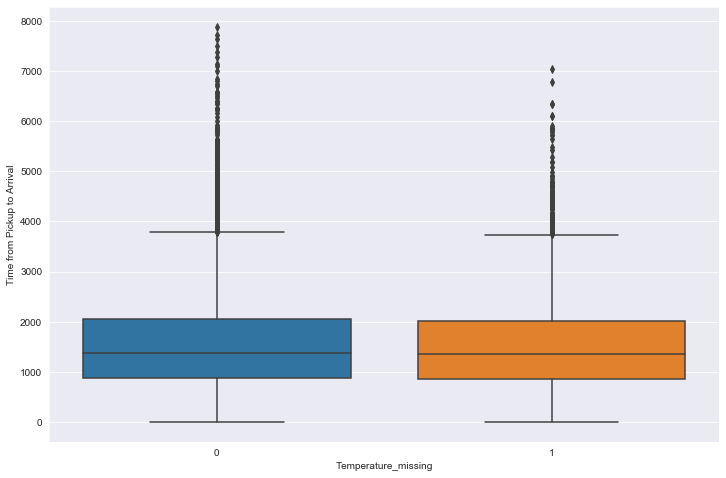

In [21]:
train_data['Temperature_missing'] = np.where(train_data['Temperature'].isnull(), 1, 0)
plt.figure(figsize=(12, 8))
sns.boxplot(data=train_data, x='Temperature_missing', y='Time from Pickup to Arrival')

###### Conclude
By now, we should be so much more familiar with the data. GOOD! Let's go a little further. Let's look at the distribution of each of our features

# Exploratory Data Analysis

###### task: write use function to generate multiple plots

In [22]:
# user function to generate multiple plots
def generateMultiPlot(df, variables, nrows, ncols, length, width, func):

    rows = range(0, nrows)
    columns = range(0, ncols)
    axis_position = list()

    for i,j in enumerate(rows):
        axis_position.append((i, j))

    for x in itertools.permutations(rows, len(columns)):
        axis_position.append(x[0:2])
    axis_position = pd.Series(axis_position).drop_duplicates().sort_values().to_list()

    var_axes = {variable: list(ax) for variable, ax in zip(variables, axis_position)}

    fig, axes = plt.subplots(nrows, ncols, figsize = (width, length))
    for variable, ax in var_axes.items():

        x = ax[1]
        y = ax[0]
        
        multiDist = func(
                      df[variable], 
                      color = "teal", 
                      ax = axes[x, y]
                    )
    return multiDist

## Time features

###### task: check to see if there are orders that are delivered the next day

In [23]:
placement_not_equal_to_confirmation = train_data['Placement - Day of Month'] != train_data['Confirmation - Day of Month']
confirmation_not_equal_to_pickup = train_data['Confirmation - Day of Month'] != train_data['Arrival at Pickup - Day of Month']
arrival_at_pick_not_equal_to_pickup = train_data['Arrival at Pickup - Day of Month'] != train_data['Pickup - Day of Month']
pickup_not_equal_to_arrival = train_data['Pickup - Day of Month'] != train_data['Arrival at Destination - Day of Month']

mask = placement_not_equal_to_confirmation | confirmation_not_equal_to_pickup | arrival_at_pick_not_equal_to_pickup | pickup_not_equal_to_arrival

train_data[mask][time_vars + ['Time from Pickup to Arrival', 'Rider Id', 'Distance (KM)']]

,Placement - Time,Confirmation - Time,Arrival at Pickup - Time,Pickup - Time,Time from Pickup to Arrival,Rider Id,Distance (KM)
4024,2:34:37 PM,1:16:53 PM,1:59:45 PM,2:01:52 PM,2640,Rider_Id_928,11
9804,12:22:05 PM,1:27:30 PM,1:32:38 PM,1:53:47 PM,1854,Rider_Id_247,8


In [24]:
datetime_vars = list()
for month_col, time_col in zip(month_day_vars, time_vars):
    new_col_name = '{}'.format(time_col.split('-')[0].replace(' ', ''))
    datetime_vars.append(new_col_name)
    print(new_col_name)
    
    values = list()
    Dates = list()
    for row in train_data.index.values:
        value = '2020' + '-' + '1' + '-' + str(train_data[month_col][row]) 
        values.append(value)
        
        date_string = values[row]
        time_string = train_data[time_col][row]

        Datetime = pd.to_datetime(date_string + ' ' + str(time_string))
#         print(Datetime)
        Dates.append(Datetime)
    train_data[new_col_name] = Dates

train_data.loc[:, datetime_vars].head()

Placement
Confirmation
ArrivalatPickup
Pickup


,Placement,Confirmation,ArrivalatPickup,Pickup
0,2020-01-09 09:35:46,2020-01-09 09:40:10,2020-01-09 10:04:47,2020-01-09 10:27:30
1,2020-01-12 11:16:16,2020-01-12 11:23:21,2020-01-12 11:40:22,2020-01-12 11:44:09
2,2020-01-30 12:39:25,2020-01-30 12:42:44,2020-01-30 12:49:34,2020-01-30 12:53:03
3,2020-01-15 09:25:34,2020-01-15 09:26:05,2020-01-15 09:37:56,2020-01-15 09:43:06
4,2020-01-13 09:55:18,2020-01-13 09:56:18,2020-01-13 10:03:53,2020-01-13 10:05:23


###### task: transform time object to Seconds (to numeric) and visualise them

In [25]:
iter_dict = {
    'Time from Placement to Confirmation': ['Confirmation', 'Placement'],
    'Time from Confirmation to Arrival at Pickup': ['ArrivalatPickup', 'Confirmation'],
    'Time from Arrival at Pickup to Actual Pickup': ['Pickup', 'ArrivalatPickup'],
    'Time from Placement to Actual Pickup': ['Pickup', 'Placement'],
    'Time from Placement to Arrival at Pickup': ['ArrivalatPickup', 'Placement'],
    'Time from Confirmation to Actual Pickup': ['Pickup', 'Confirmation']
}
numeric_time_vars_sub = list()
for new_column, inputs in iter_dict.items():
    numeric_time_vars_sub.append(new_column)
    col1 = inputs[0]
    col2 = inputs[1]
    train_data[new_column] = train_data[col1] - train_data[col2]
    train_data[new_column] = train_data[new_column].map(lambda timedelt: timedelt.total_seconds())

train_data.loc[:, numeric_time_vars_sub].head()

,Time from Placement to Confirmation,Time from Confirmation to Arrival at Pickup,Time from Arrival at Pickup to Actual Pickup,Time from Placement to Actual Pickup,Time from Placement to Arrival at Pickup,Time from Confirmation to Actual Pickup
0,264.0,1477.0,1363.0,3104.0,1741.0,2840.0
1,425.0,1021.0,227.0,1673.0,1446.0,1248.0
2,199.0,410.0,209.0,818.0,609.0,619.0
3,31.0,711.0,310.0,1052.0,742.0,1021.0
4,60.0,455.0,90.0,605.0,515.0,545.0


In [26]:
train_data.loc[:, numeric_time_vars_sub].describe()

,Time from Placement to Confirmation,Time from Confirmation to Arrival at Pickup,Time from Arrival at Pickup to Actual Pickup,Time from Placement to Actual Pickup,Time from Placement to Arrival at Pickup,Time from Confirmation to Actual Pickup
count,21201.000000,21201.000000,21201.000000,21201.000000,21201.000000,21201.000000
mean,445.456960,776.521438,744.186406,1966.164804,1221.978397,1520.707844
std,1681.658749,687.758556,761.216606,1972.847268,1842.413655,978.439623
min,-42.000000,0.000000,60.000000,78.000000,-6.000000,66.000000
25%,27.000000,303.000000,263.000000,981.000000,423.000000,836.000000
50%,69.000000,614.000000,491.000000,1540.000000,837.000000,1269.000000
75%,289.000000,1045.000000,929.000000,2478.000000,1555.000000,1939.000000
max,176725.000000,6374.000000,5985.000000,178302.000000,177033.000000,9836.000000


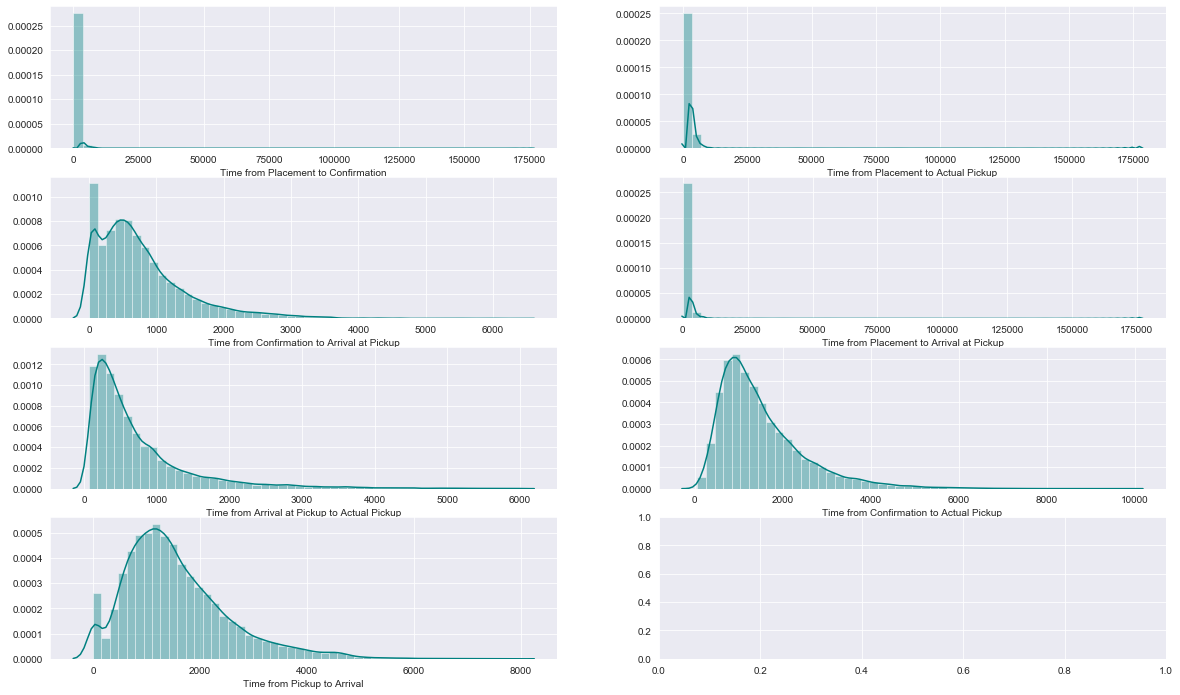

In [27]:
generateMultiPlot(
    df = train_data,
    variables = numeric_time_vars_sub[0:3] + ['Time from Pickup to Arrival'] + numeric_time_vars_sub[3:],
    nrows = 4,
    ncols = 2,
    length = 12,
    width = 20,
    func = sns.distplot
)

In [28]:
placement  = train_data['Time from Placement to Confirmation']
train_data[placement < 0][['Time from Placement to Confirmation'] + datetime_vars + month_day_vars].head()

,Time from Placement to Confirmation,Placement,Confirmation,ArrivalatPickup,Pickup,Placement - Day of Month,Confirmation - Day of Month,Arrival at Pickup - Day of Month,Pickup - Day of Month
3173,-26.0,2020-01-25 17:47:00,2020-01-25 17:46:34,2020-01-25 17:47:02,2020-01-25 17:56:10,25,25,25,25
6805,-42.0,2020-01-30 13:28:33,2020-01-30 13:27:51,2020-01-30 13:41:55,2020-01-30 13:49:44,30,30,30,30
10597,-1.0,2020-01-05 10:30:40,2020-01-05 10:30:39,2020-01-05 10:38:04,2020-01-05 10:44:54,5,5,5,5
11083,-13.0,2020-01-28 09:30:05,2020-01-28 09:29:52,2020-01-28 09:38:48,2020-01-28 09:51:11,28,28,28,28
16331,-12.0,2020-01-20 13:45:32,2020-01-20 13:45:20,2020-01-20 13:45:26,2020-01-20 13:47:43,20,20,20,20


In [29]:
index_to_replace_w_zero = train_data[placement < 0].index.to_list()
train_data.loc[index_to_replace_w_zero, 'Time from Placement to Confirmation'] = 0

##### Analysing the target variable

###### task: apply transformations and visualise

In [30]:
target_raw = train_data.loc[:, 'Time from Pickup to Arrival'].copy()

mask = target_raw > 60 * 0
target_raw = target_raw[mask]

target_log_transformed = np.log(target_raw)
target_sq_transformed = np.sqrt(target_raw)

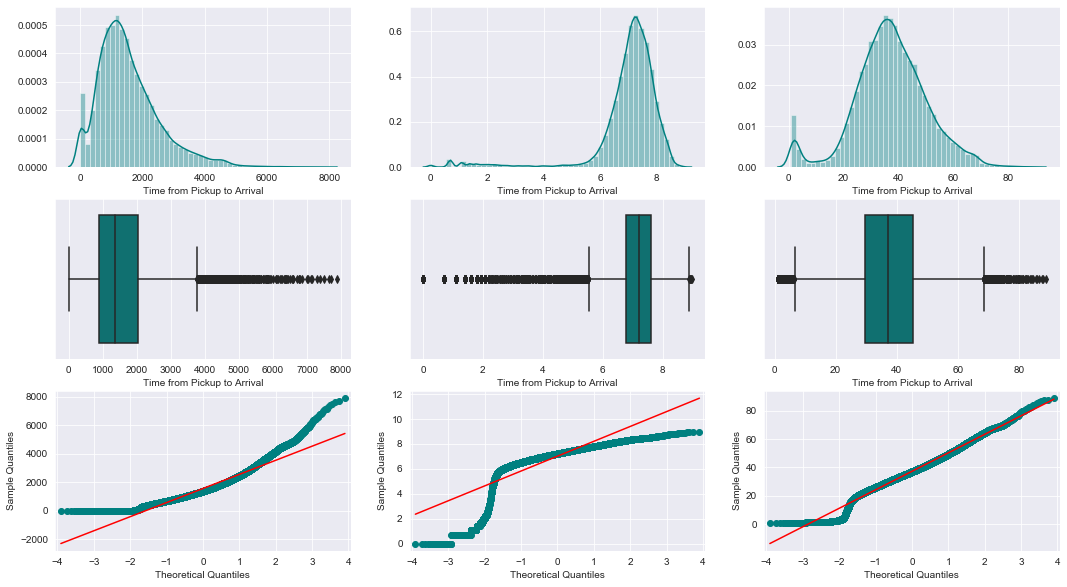

In [31]:
fig, ax = plt.subplots(nrows = 3, ncols = 3, figsize = (18, 10))

dist = sns.distplot(target_raw, color = "teal", ax = ax[0, 0])
box = sns.boxplot(target_raw, color = "teal", ax = ax[1, 0], orient='h')
qq = sm.qqplot(target_raw, line = 's', color = 'teal', ax = ax[2, 0])


dist = sns.distplot(target_log_transformed, color = "teal", ax = ax[0, 1])
box = sns.boxplot(target_log_transformed, color = "teal", ax = ax[1, 1], orient='h')
qq = sm.qqplot(target_log_transformed, line = 's', color = 'teal', ax = ax[2, 1])

dist = sns.distplot(target_sq_transformed, color = "teal", ax = ax[0, 2])
box = sns.boxplot(target_sq_transformed, color = "teal", ax = ax[1, 2], orient='h')
qq = sm.qqplot(target_sq_transformed, line = 's', color = 'teal', ax = ax[2, 2])

##### Benchmark Model

###### task: minimal data preprocessing

In [32]:
predictors = list(set(numeric_time_vars_sub) - set(missings_vars))
X = train_data.loc[:, predictors][mask]
X.head()

,Time from Confirmation to Actual Pickup,Time from Placement to Actual Pickup,Time from Arrival at Pickup to Actual Pickup,Time from Placement to Arrival at Pickup,Time from Placement to Confirmation,Time from Confirmation to Arrival at Pickup
0,2840.0,3104.0,1363.0,1741.0,264.0,1477.0
1,1248.0,1673.0,227.0,1446.0,425.0,1021.0
2,619.0,818.0,209.0,609.0,199.0,410.0
3,1021.0,1052.0,310.0,742.0,31.0,711.0
4,545.0,605.0,90.0,515.0,60.0,455.0


###### task: fit linear regression and cross validate performance

In [33]:
from sklearn.linear_model import LinearRegression
from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import SCORERS

X_train = X
y_train = target_raw.values

def Squared(x):
    return x ** 2

regressor = LinearRegression()
regressor1 = TransformedTargetRegressor(
    regressor=LinearRegression(), func=np.log, inverse_func=np.exp)
regressor2 = TransformedTargetRegressor(
    regressor=LinearRegression(), func=np.sqrt, inverse_func=Squared)

my_dict = {
    'Raw Target': regressor,
    'Log Transformed Target': regressor1,
    'Square Root Transformed Target': regressor2
}

scores = {}
for target, model in my_dict.items():
    errors = cross_val_score(estimator=model,
                             X=X_train,
                             y=y_train,
                             cv=10,
                             scoring='neg_root_mean_squared_error')
    errors = np.array([abs(value) for value in errors])
    scores[target] = pd.Series(errors)

In [34]:
pd.DataFrame(scores).mean()

Raw Target                         969.207270
Log Transformed Target            1186.788540
Square Root Transformed Target     985.141437
dtype: float64

In [35]:
(pd.DataFrame(scores).mean() / np.mean(target_raw)) * 100

Raw Target                        62.251540
Log Transformed Target            76.226641
Square Root Transformed Target    63.274981
dtype: float64

##### Outliers

###### task: detect and treat outliers

In [36]:
# from feature_engine.outlier_removers import OutlierTrimmer, Winsorizer

# target = ['Time from Pickup to Arrival']
# predictors = list(set(numeric_vars + numeric_time_vars) - set(missings_vars)) 
# data = train_data.loc[:,predictors + target].dropna()
# outlier_trimmer = Winsorizer(distribution='gaussian', tail='both', fold=1.5)
# outlier_trimmer.fit(data)
# data_trimmed = outlier_trimmer.fit_transform(data)

# print('Lengths: Untreated', str(len(data_trimmed.index)))

# X = data_trimmed.loc[:, predictors]
# y = data_trimmed.loc[:, target]

# regressor = LinearRegression()
# errors = cross_val_score(estimator=regressor, X=X, y=y, cv=10, scoring='neg_root_mean_squared_error')
# errors = np.array([abs(value) for value in errors])
# (((pd.Series(errors).mean()) / np.mean(target_raw)) * 100).round(2)

In [37]:
# user function to fit and train models treated with diffrent outliers methods
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score

def modelEvalOutliers(df, predictors, target, splits, strategy, tail, variables, fold, distribution):

    RMSE = list()
    R2_score = list()
    Error_rate = list()
    kf = KFold(n_splits=splits, shuffle=True)
    for train_index, test_index in kf.split(df):

        train_df = df.loc[train_index, predictors + target]
        test_df = df.loc[test_index, predictors + target]

        outlier_treat = strategy(distribution = distribution, tail = tail, variables = variables, fold = fold)
        outlier_treat.fit(train_df)
        train_df_treated = outlier_treat.fit_transform(train_df)
        
#         print('Length of train_df b4 & after:', str(len(train_df.index)), str(len(train_df_treated.index)))
        
        X_train = train_df_treated.loc[:, predictors]
        y_train = train_df_treated.loc[:, target]
        X_val = test_df.loc[:, predictors]
        y_val = test_df.loc[:, target]

        regressor = LinearRegression()
        regressor.fit(X=X_train, y=y_train)
        y_pred = regressor.predict(X_val)

        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        r_sq = r2_score(y_val, y_pred)
        error_rate = rmse / np.mean(y_val)                         

        RMSE.append(rmse)
        R2_score.append(r_sq)
        Error_rate.append(error_rate)
    perfomance = pd.DataFrame({'RMSE': RMSE, 'R2_Score': R2_score, 'Error rate': Error_rate})
    
    return perfomance

In [38]:
from feature_engine.outlier_removers import OutlierTrimmer, Winsorizer

target = ['Time from Pickup to Arrival']
predictors = list(set(numeric_time_vars_sub) - set(missings_vars))
data = train_data.loc[:, predictors + target]

strategies = {
    'Trimmer - Mean & Std': [OutlierTrimmer, 'gaussian'],
    'Trimmer - IQR': [OutlierTrimmer, 'skewed'],
    'Capping - Mean & Std': [Winsorizer, 'gaussian'],
    'Capping - IQR': [Winsorizer, 'skewed']
}

folds = [0.5, 1, 1.5, 2, 3, 3.5, 4, 4.5, 5]
perfomance = pd.DataFrame()
for strategy, elements in strategies.items():
    
#     print('Strategy:', strategy)
#     print('class:', elements[0])
#     print('Distribution:', elements[-1])
    for fold in folds:
#         print(fold)

        model_output = modelEvalOutliers(
            df = data, 
            predictors = predictors, 
            target = target,
            splits=10,
            strategy = elements[0],distribution=elements[-1], tail='both', variables=predictors, fold=fold
        )
        
        model_output['Fold'] = fold
        model_output['Strategy'] = strategy

        perfomance = pd.concat([perfomance, model_output])

In [39]:
results = perfomance.groupby(['Strategy', 'Fold']).mean().reset_index()
results.head()

,Strategy,Fold,RMSE,R2_Score
0,Capping - IQR,0.5,972.580970,0.028561
1,Capping - IQR,1.0,972.448627,0.029227
2,Capping - IQR,1.5,977.483132,0.018801
3,Capping - IQR,2.0,981.122387,0.011182
4,Capping - IQR,3.0,980.809808,0.011403


In [40]:
results[results['RMSE'] == results['RMSE'].min()]

,Strategy,Fold,RMSE,R2_Score
17,Capping - Mean & Std,5.0,969.858433,0.033851


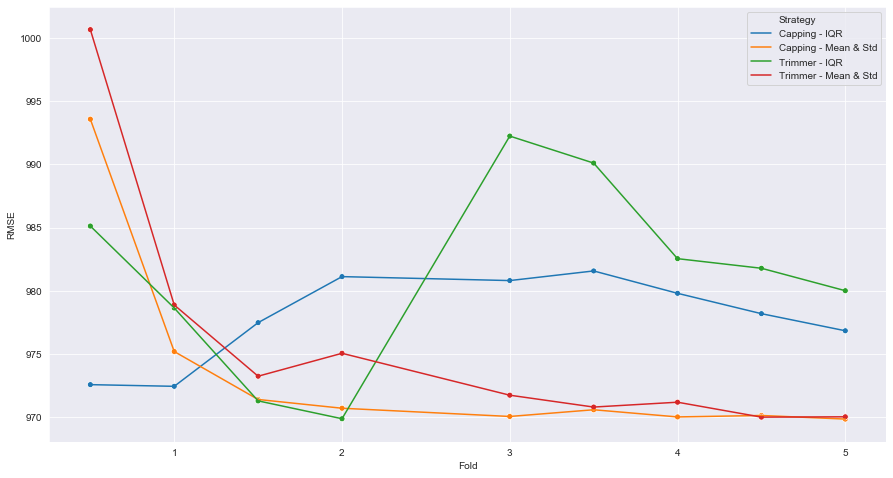

In [41]:
fig = plt.figure(figsize = (15, 8))
sns.lineplot(data = results, x = 'Fold', y = 'RMSE', hue='Strategy')
sns.scatterplot(data = results, x = 'Fold', y = 'RMSE', hue='Strategy', legend = False)

In [42]:
train_data.loc[:, time_vars].head()

,Placement - Time,Confirmation - Time,Arrival at Pickup - Time,Pickup - Time
0,9:35:46 AM,9:40:10 AM,10:04:47 AM,10:27:30 AM
1,11:16:16 AM,11:23:21 AM,11:40:22 AM,11:44:09 AM
2,12:39:25 PM,12:42:44 PM,12:49:34 PM,12:53:03 PM
3,9:25:34 AM,9:26:05 AM,9:37:56 AM,9:43:06 AM
4,9:55:18 AM,9:56:18 AM,10:03:53 AM,10:05:23 AM


In [45]:
am_pm_vars = list()
for column_name in time_vars:
    new_column_name = '{}_made_AM/PM'.format(column_name.split('-')[0].replace(' ', ''))
    am_pm_vars.append(new_column_name)
    train_data[new_column_name] = train_data.loc[:, column_name].map(lambda string: string.split()[1])
train_data.loc[:, am_pm_vars].head()

,Placement_made_AM/PM,Confirmation_made_AM/PM,ArrivalatPickup_made_AM/PM,Pickup_made_AM/PM
0,AM,AM,AM,AM
1,AM,AM,AM,AM
2,PM,PM,PM,PM
3,AM,AM,AM,AM
4,AM,AM,AM,AM


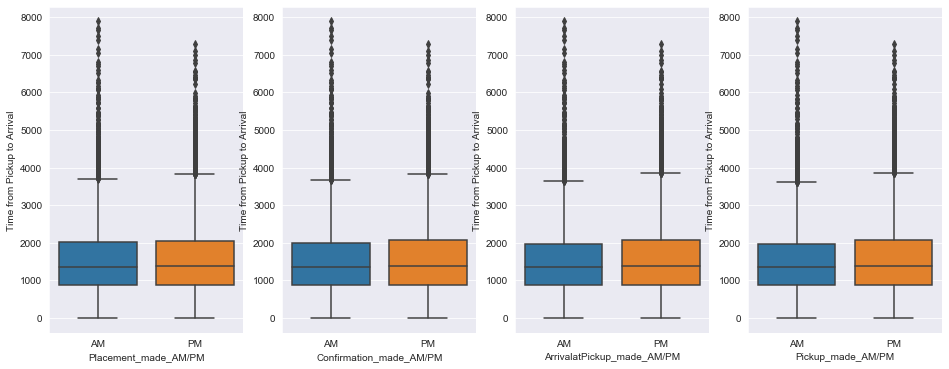

In [46]:
fig, axes = plt.subplots(1, 4, figsize = (16, 6))
for axe, col in zip([0, 1, 2, 3], am_pm_vars):
    sns.boxplot(data = train_data, x = col, y = 'Time from Pickup to Arrival', ax = axes[axe])

In [47]:
train_data.loc[:, datetime_vars].head()

,Placement,Confirmation,ArrivalatPickup,Pickup
0,2020-01-09 09:35:46,2020-01-09 09:40:10,2020-01-09 10:04:47,2020-01-09 10:27:30
1,2020-01-12 11:16:16,2020-01-12 11:23:21,2020-01-12 11:40:22,2020-01-12 11:44:09
2,2020-01-30 12:39:25,2020-01-30 12:42:44,2020-01-30 12:49:34,2020-01-30 12:53:03
3,2020-01-15 09:25:34,2020-01-15 09:26:05,2020-01-15 09:37:56,2020-01-15 09:43:06
4,2020-01-13 09:55:18,2020-01-13 09:56:18,2020-01-13 10:03:53,2020-01-13 10:05:23


In [48]:
hour_vars = list()
minute_vars = list()
for col in datetime_vars:
    hours = list()
    minutes = list()
    for order in train_data.index.values:
        hour = train_data.loc[:, col][order].hour
        minute = train_data.loc[:, col][order].minute
        hours.append(hour)
        minutes.append(minute)
#     print(col)
#     print(hours, minutes)
    new_column_name_hour = '{}_hour'.format(col)
    new_column_name_minute = '{}_minute'.format(col)
    hour_vars.append(new_column_name_hour)
    minute_vars.append(new_column_name_minute)
    
    train_data[new_column_name_hour] = hours
    train_data[new_column_name_minute] = minutes
        
train_data.loc[:, hour_vars + minute_vars].head()

,Placement_hour,Confirmation_hour,ArrivalatPickup_hour,Pickup_hour,Placement_minute,Confirmation_minute,ArrivalatPickup_minute,Pickup_minute
0,9,9,10,10,35,40,4,27
1,11,11,11,11,16,23,40,44
2,12,12,12,12,39,42,49,53
3,9,9,9,9,25,26,37,43
4,9,9,10,10,55,56,3,5


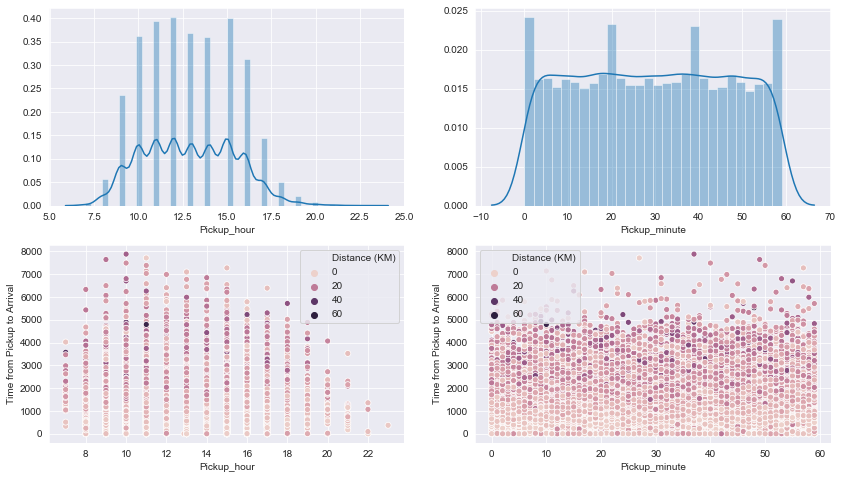

In [58]:
fig, axes = plt.subplots(2, 2, figsize = (14, 8))
sns.distplot(train_data['Pickup_hour'], ax=axes[0,0])
sns.scatterplot(data=train_data, x= 'Pickup_hour', y='Time from Pickup to Arrival', ax=axes[1,0], hue='Distance (KM)')

sns.distplot(train_data['Pickup_minute'], ax=axes[0,1])
sns.scatterplot(data=train_data, x= 'Pickup_minute', y='Time from Pickup to Arrival', ax= axes[1,1], hue='Distance (KM)')

In [57]:
ind_to_replace = train_data[train_data['Pickup_hour'] ==0].loc[:, 'Pickup_hour'].index

In [56]:
train_data.loc[ind_to_replace, 'Pickup_hour'] = np.mean(train_data['Pickup_hour'])

##### Discretisation

In [59]:
from feature_engine.discretisers import EqualWidthDiscretiser, EqualFrequencyDiscretiser
from feature_engine.categorical_encoders import OrdinalCategoricalEncoder

def applyDescritiser(X, y, discritiser, bins, variables):
    disc = discritiser(bins, variables = variables, return_object=True)
    disc.fit(X)
    X_discr = disc.transform(X)

    enc = OrdinalCategoricalEncoder(encoding_method='ordered')
    enc.fit(X_discr, y)
    return enc.transform(X_discr)

def plotBins(df):
    comb_data = train_data.copy()
    comb_data['Pickup_hour_bins'] = df['Pickup_hour'].astype('category')
    comb_data['Time from Pickup to Arrival'] = y

    fig, axes = plt.subplots(1, 2, figsize = (14, 5))
    fig = sns.barplot(data = comb_data, x = 'Pickup_hour_bins', y = 'Time from Pickup to Arrival', ax=axes[1])
    fig = sns.lineplot(data = comb_data, x = 'Pickup_hour_bins', y = 'Time from Pickup to Arrival', ax=axes[1])

    fig = sns.scatterplot(data=comb_data, x= 'Pickup_hour', y='Time from Pickup to Arrival', ax=axes[0], hue='Pickup_hour_bins', legend = False)
    return fig

In [60]:
predictors = numeric_time_vars_sub + [hour_vars[3]] + [am_pm_vars[3]]
predictors

['Time from Placement to Confirmation',
 'Time from Confirmation to Arrival at Pickup',
 'Time from Arrival at Pickup to Actual Pickup',
 'Time from Placement to Actual Pickup',
 'Time from Placement to Arrival at Pickup',
 'Time from Confirmation to Actual Pickup',
 'Pickup_hour',
 'Pickup_made_AM/PM']

In [61]:
X = train_data.loc[:, predictors]
y = train_data['Time from Pickup to Arrival'][mask]

X_ew_discr = applyDescritiser(X, y,
    discritiser=EqualWidthDiscretiser, bins = 6, variables=['Pickup_hour']
)
X_ef_discr = applyDescritiser(X, y,
    discritiser=EqualFrequencyDiscretiser, bins = 6, variables=['Pickup_hour']
)

Text(0.5, 1.0, 'Equal frequency bins')

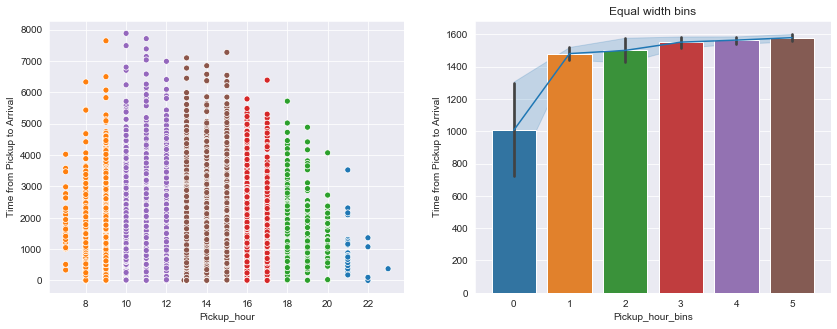

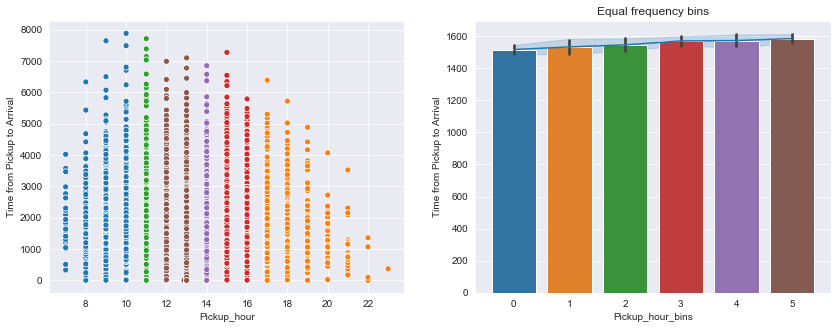

In [62]:
plotBins(X_ew_discr)
plt.title('Equal width bins')
plotBins(X_ef_discr)
plt.title('Equal frequency bins')

###### task: supervised bins

In [79]:
from feature_engine.discretisers import DecisionTreeDiscretiser
DT_disc = DecisionTreeDiscretiser(
                        cv=10,
                        scoring='neg_root_mean_squared_error',
                        variables=['Pickup_hour'],
                        regression=True,
                        param_grid={'max_depth': [1, 2, 3],
                                    'min_samples_leaf': [10, 4]},
                        random_state=1)
X = train_data.loc[:, ['Pickup_hour']]
y = train_data.loc[:, 'Time from Pickup to Arrival']
DT_disc.fit(X, y)
DT_discr = DT_disc.transform(X)

In [80]:
list(DT_discr['Pickup_hour'].unique())

[1565.8037495430572, 1474.0321446509292, 1006.5555555555555, 1845.0]

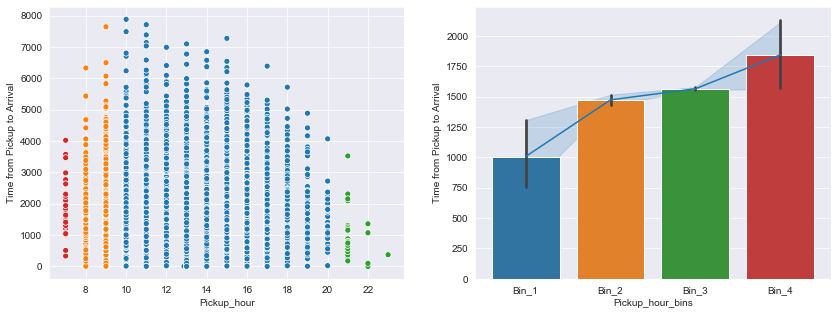

In [81]:
DT_discr['Pickup_hour'] = np.where(
    DT_discr['Pickup_hour'] == 1006.5555555555555, 'Bin_1',
    np.where(
        DT_discr['Pickup_hour'] == 1474.0321446509292, 'Bin_2',
        np.where(
            DT_discr['Pickup_hour'] == 1565.8037495430572, 'Bin_3',
            np.where(
                DT_discr['Pickup_hour'] == 1845.0, 'Bin_4',

                DT_discr['Pickup_hour']
            )
        )
    )
)


plotBins(DT_discr)

In [82]:
DT_discr['Pickup_hour'].value_counts()

Bin_3    19149
Bin_2     1991
Bin_4       34
Bin_1       27
Name: Pickup_hour, dtype: int64

In [90]:
print('Pickup_hour score - Error rate: ', (abs(DT_disc.scores_dict_['Pickup_hour']) / np.mean(train_data['Time from Pickup to Arrival']) * 100).round(2))

Pickup_hour score - Error rate:  63.37


###### Assessing the perfomance of discretisation

In [93]:
predictors[:-1]

['Time from Placement to Confirmation',
 'Time from Confirmation to Arrival at Pickup',
 'Time from Arrival at Pickup to Actual Pickup',
 'Time from Placement to Actual Pickup',
 'Time from Placement to Arrival at Pickup',
 'Time from Confirmation to Actual Pickup',
 'Pickup_hour']

In [172]:
X = train_data.loc[:, predictors[:-1]]
y = train_data['Time from Pickup to Arrival']

#####################################################################

def modelEvalDiscretisation(strategy, bins, variables, model):
    RMSE = list()
    R2_score = list()
    Error_rate = list()

    cv = KFold(n_splits=10, shuffle=True, random_state=111)
    for train_index, test_index in cv.split(X):
        X_train = X.loc[train_index, ]
        y_train = y[train_index]
        X_val = X.loc[test_index, ]
        y_val = y[test_index]

        disc = strategy(bins, variables = variables, return_object=True)
        disc.fit(X_train)
        X_train_trans = disc.transform(X_train)
        X_val_trans = disc.transform(X_val)

        enc = OrdinalCategoricalEncoder(encoding_method='ordered')
        enc.fit(X_train_trans, y)
        X_train['Pickup_hour_bins'] = enc.transform(X_train_trans)['Pickup_hour']
        X_val['Pickup_hour_bins'] = enc.transform(X_val_trans)['Pickup_hour']
        
        X_train.pop('Pickup_hour')
        X_val.pop('Pickup_hour')
        
        regressor = model()
        regressor.fit(X=X_train, y=y_train)
        y_pred = regressor.predict(X_val)

        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        r_sq = r2_score(y_val, y_pred)
        error_rate = rmse / np.mean(y_val)


        RMSE.append(rmse)
        R2_score.append(r_sq)
        Error_rate.append(error_rate)
        perfomance = pd.DataFrame(
            {'RMSE': RMSE, 'R2_Score': R2_score, 'Error rate': Error_rate}
        )
    return perfomance

In [173]:
strategies = {
    'Equal Width Discretiser': {'descritiser': EqualWidthDiscretiser, 'bins': [3, 4, 5, 6, 7, 8], 'models': [LinearRegression]},
    'Equal Frequency Discretiser': {'descritiser': EqualFrequencyDiscretiser, 'bins': [3, 4, 5, 6, 7, 8], 'models': [LinearRegression]}
}

perfomance = pd.DataFrame()

for strategy, elements in strategies.items():
    print(strategy, elements['descritiser'], elements['bins'], elements['models'])
    
    for interval in elements['bins']:
        for model in elements['models']:
            output = modelEvalDiscretisation(
                strategy = elements['descritiser'],
                bins = interval,
                variables = ['Pickup_hour'],
                model = model
            ) 
            output['Strategy'] = strategy
            output['bins'] = interval
            perfomance = pd.concat([perfomance, output])

Equal Width Discretiser <class 'feature_engine.discretisers.EqualWidthDiscretiser'> [3, 4, 5, 6, 7, 8] [<class 'sklearn.linear_model._base.LinearRegression'>]
Equal Frequency Discretiser <class 'feature_engine.discretisers.EqualFrequencyDiscretiser'> [3, 4, 5, 6, 7, 8] [<class 'sklearn.linear_model._base.LinearRegression'>]


In [174]:
perfomance

,RMSE,R2_Score,Error rate,Strategy,bins
0,1012.740502,0.019578,0.644403,Equal Width Discretiser,3
1,993.648826,0.041713,0.643126,Equal Width Discretiser,3
2,973.438038,0.040649,0.627535,Equal Width Discretiser,3
3,947.719429,0.047824,0.604202,Equal Width Discretiser,3
4,981.731361,0.029188,0.625948,Equal Width Discretiser,3
...,...,...,...,...,...
5,937.170037,0.017128,0.616811,Equal Frequency Discretiser,8
6,946.231378,0.045352,0.605746,Equal Frequency Discretiser,8
7,970.064394,0.037131,0.617196,Equal Frequency Discretiser,8
8,970.618492,0.030243,0.625746,Equal Frequency Discretiser,8


In [175]:
perfomance[perfomance['Error rate'] == perfomance['Error rate'].min()]

,RMSE,R2_Score,Error rate,Strategy,bins
3,947.535528,0.048193,0.604084,Equal Width Discretiser,4


##### Analysing  features

###### task: plot numeric features
What better way to learn more about a dataset than by actually viualising it. Here we visualise numeric features. We lookout for the following:
1. outliers - these are values that lie too far are away from the rest of the other values in the vector of the target (the variable we attempt to predict)
2. leverage points - same as outliers except that this time we refer to predictor features.

The motivation for investigating and treating these values is as follows: outlier values and/or leverage points in data distributions sometimes have an impact in the pattern that is learnt by the models we build later. The term high leverage refers to the tendency of such values to affect the fit of the line, particularly in parameterised models like linear regression. As such, treating them accordingly allows such models to learn the underlying trend/distribution of the data, rather than one time instances that may never again occur in the data and at times these values are the result of data collection errors. The code cel below displays histograms for all numeric features.

In [45]:
# summary statistic
train_data.loc[:, numeric_vars].describe()

,Distance (KM),Temperature,Precipitation in millimeters,No_Of_Orders,Age,Average_Rating,No_of_Ratings
count,21201.000000,16835.000000,552.000000,21201.000000,21201.000000,21201.000000,21201.000000
mean,9.506533,23.258889,7.905797,1692.423706,984.742842,13.882520,341.067119
std,5.668963,3.615768,17.089971,1574.308302,646.652835,0.916071,402.867746
min,1.000000,11.200000,0.100000,2.000000,96.000000,0.000000,0.000000
25%,5.000000,20.600000,1.075000,557.000000,495.000000,13.600000,61.000000
50%,8.000000,23.500000,2.900000,1212.000000,872.000000,14.000000,161.000000
75%,13.000000,26.000000,4.900000,2311.000000,1236.000000,14.300000,495.000000
max,49.000000,32.100000,99.100000,9756.000000,3764.000000,15.200000,2298.000000


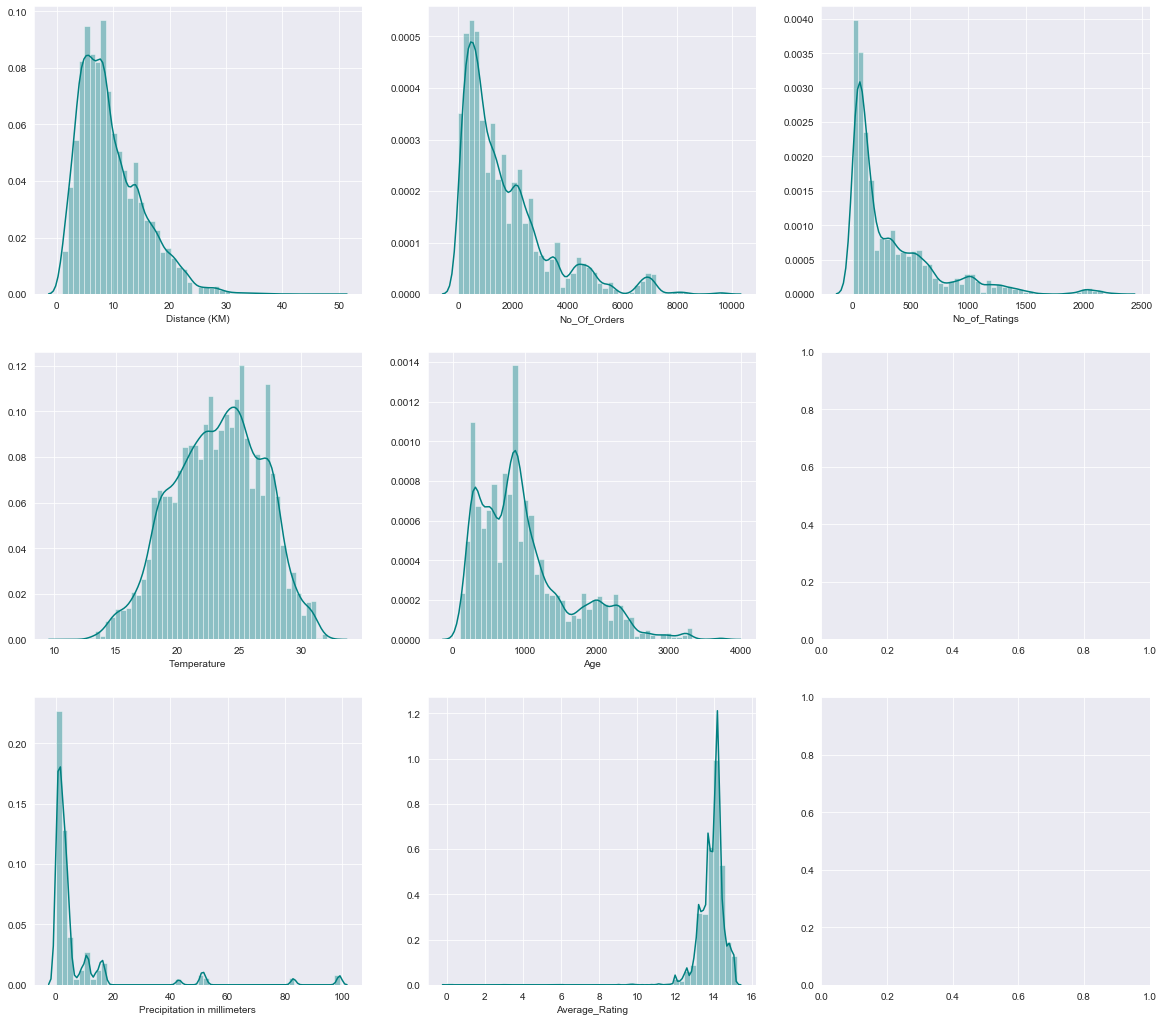

In [46]:
# generate histograms for numeric features
generateMultiPlot(
    df = train_data,
    variables = numeric_vars,
    nrows = 3,
    ncols = 3,
    length = 18,
    width = 20,
    func = sns.distplot
)

###### task: plot barchars for factors
When generating barchars for factor variables we look out for features with too many categories that can be grouped together. The grouping can depend on how the different levels relate to the target variable. For example if there is inherent ordering of the levels with the target fewer categories can be created by grouping based on a scale of low, medium and high values of the target. This is called mean target encoding and is an option we may look into for feature with too many level like day of the month (usually 30 levels).

In [29]:
train_data.loc[:, factor_vars].describe()

,Vehicle Type,Placement - Weekday (Mo = 1),Arrival at Pickup - Weekday (Mo = 1),Confirmation - Weekday (Mo = 1),Pickup - Weekday (Mo = 1),Placement - Day of Month,Arrival at Pickup - Day of Month,Confirmation - Day of Month,Pickup - Day of Month,Platform Type,Personal or Business
count,21201,21201,21201,21201,21201,21201,21201,21201,21201,21201,21201
unique,1,7,7,7,7,31,31,31,31,4,2
top,Bike,4,4,4,4,8,8,8,8,3,Business
freq,21201,4228,4229,4229,4229,848,848,848,848,18054,17384


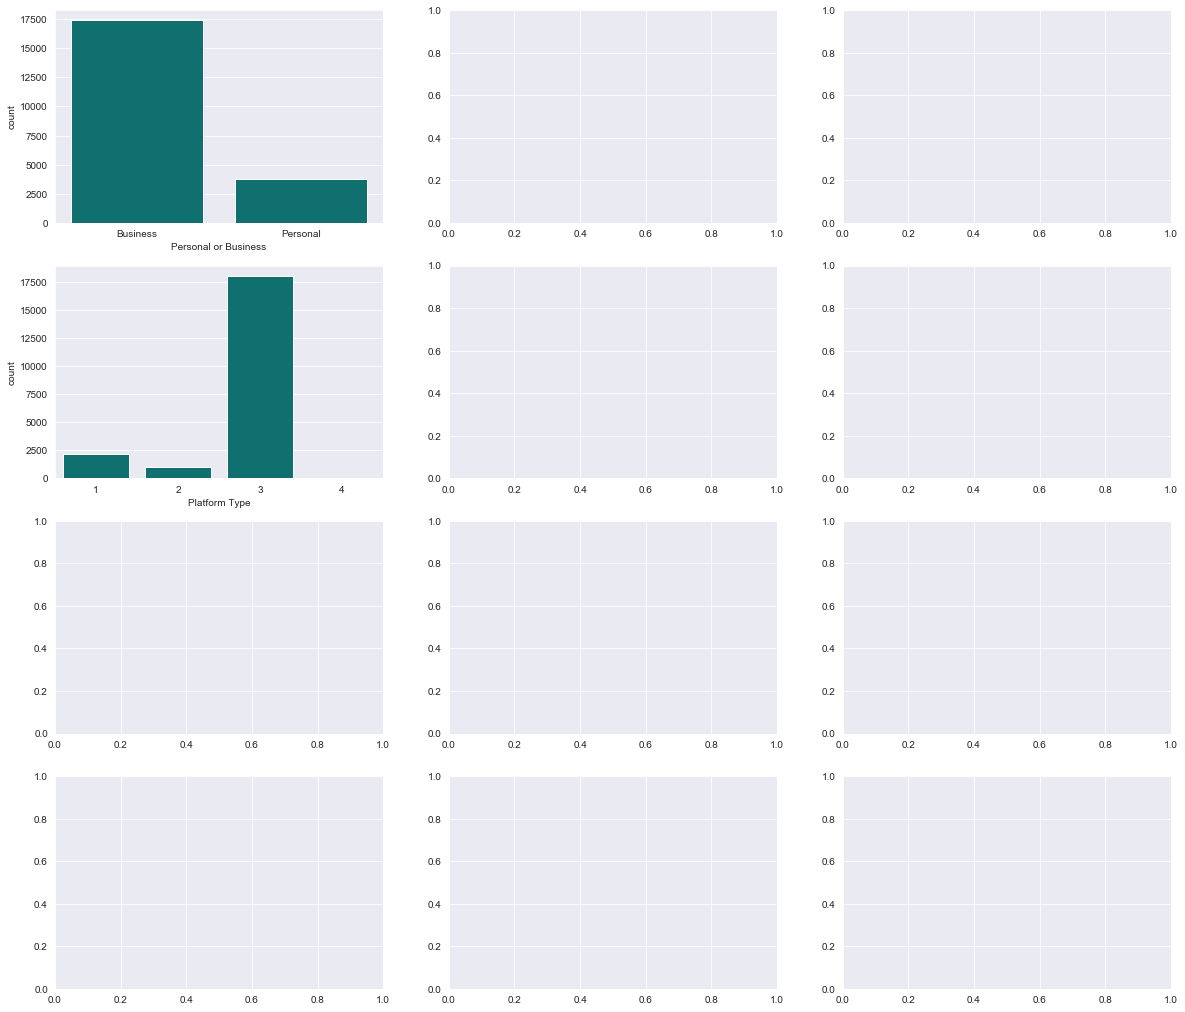

In [186]:
generateMultiPlot(
    df = train_data,
    variables = factor_vars[1:],
    nrows = 4,
    ncols = 3,
    length = 18,
    width = 20,
    func = sns.countplot
)

## Multivariate Analysis

In [7]:
# analyse relationships between features (correlation and factor analysis)

In [8]:
# check for collinearity and multi-collinearity

In [ ]:
# analyses relationship between features and target

# Feature Engineering

In [ ]:
# investigate non linearity

In [ ]:
# investigate feature interactions and synergy

In [ ]:
# other transformations (data mining)

# Feature Selection

In [ ]:
# L1 and L2 Regularisation

In [9]:
# forward selection, backward selection and/or mixed selection

In [10]:
# genetic algorithms (borita)

In [ ]:
# Random forests and feature importance

# Model Selection 

In [ ]:
# fit multiple models and do hyper-parameter tuning

In [ ]:
# cross validate model perfomance

In [ ]:
# select the best model and implement it as final solution

# Summary of Conclusions

In [ ]:
# summarise findings and make recommendations